<a href="https://colab.research.google.com/github/ahimsaj/ML-Training/blob/main/Time_Series_Analysis_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
filename = '../input/pune_1965_to_2002.csv'

In [5]:
rainfall_data_matrix = pd.read_csv('/content/pune_1965_to_2002.csv')
rainfall_data_matrix.set_index('Year', inplace=True)
rainfall_data_matrix = rainfall_data_matrix.transpose()
rainfall_data_matrix

Year,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,...,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
Jan,0.029,0.905,0.248,0.318,0.248,0.070,0.000,0.000,0.000,0.000,...,0.000,0.879,0.695,0.016,1.284,0.008,0.000,0.000,0.147,0.231
Feb,0.069,0.000,3.390,3.035,2.524,0.000,0.000,0.029,2.969,0.000,...,0.078,0.325,0.000,2.779,0.000,2.671,1.431,0.170,0.000,0.911
Mar,0.000,0.000,1.320,1.704,0.334,0.001,0.000,0.000,0.234,6.427,...,1.211,2.415,1.770,0.087,0.747,0.073,0.000,0.000,2.178,0.388
Apr,21.667,2.981,13.482,23.307,4.569,16.218,0.812,5.982,3.925,16.864,...,2.062,16.823,25.949,6.318,23.912,0.377,0.642,1.193,1.528,53.266
May,17.859,63.008,11.116,7.441,6.213,68.036,57.691,19.101,14.978,51.209,...,3.248,33.378,23.964,5.134,4.664,15.717,35.828,26.237,7.860,18.430
Jun,102.111,94.088,251.314,179.872,393.682,300.546,297.187,132.413,304.484,148.697,...,234.068,749.030,163.515,453.607,673.831,238.609,415.471,371.328,247.982,509.145
Jul,606.071,481.942,780.006,379.354,678.354,330.502,122.195,338.484,696.024,405.359,...,450.088,707.986,501.461,558.586,422.913,590.663,277.137,265.417,279.547,84.936
Aug,402.521,59.386,181.069,171.979,397.335,283.476,372.693,68.741,256.932,319.651,...,150.278,230.898,114.206,212.489,541.579,362.357,98.616,220.814,189.404,257.205
Sep,69.511,150.624,183.757,219.884,205.413,158.640,286.056,120.415,183.206,288.533,...,101.928,115.509,288.262,203.642,60.477,243.444,225.962,147.196,158.025,78.269
Oct,5.249,1.308,50.404,73.997,24.014,115.758,39.424,1.078,101.805,188.876,...,225.904,116.348,84.359,176.471,31.050,96.324,180.300,38.246,135.518,21.486


In [6]:
dates = pd.date_range(start='1965-01', freq='MS', periods=len(rainfall_data_matrix.columns)*12)
dates

DatetimeIndex(['1965-01-01', '1965-02-01', '1965-03-01', '1965-04-01',
               '1965-05-01', '1965-06-01', '1965-07-01', '1965-08-01',
               '1965-09-01', '1965-10-01',
               ...
               '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01',
               '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01',
               '2002-11-01', '2002-12-01'],
              dtype='datetime64[ns]', length=456, freq='MS')

Text(0.5, 1.0, 'Month vs Precipitation across all years')

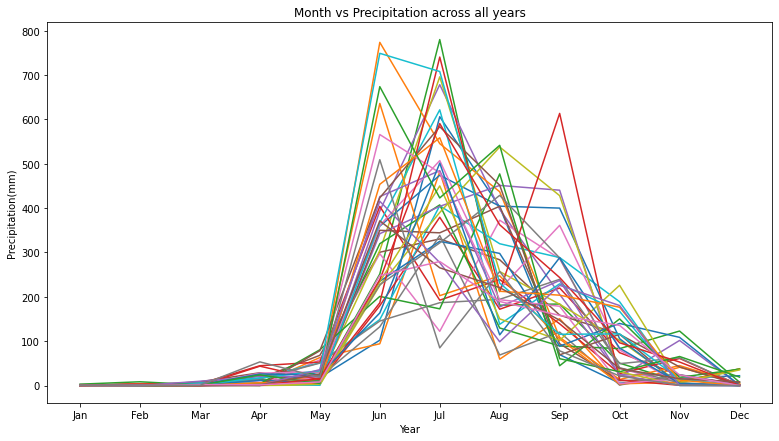

In [7]:
plt.figure(figsize=(13,7))
plt.plot(rainfall_data_matrix)
plt.xlabel('Year')
plt.ylabel('Precipitation(mm)')
plt.title('Month vs Precipitation across all years')

Text(0.5, 1.0, 'Month vs Precipitation across all years')

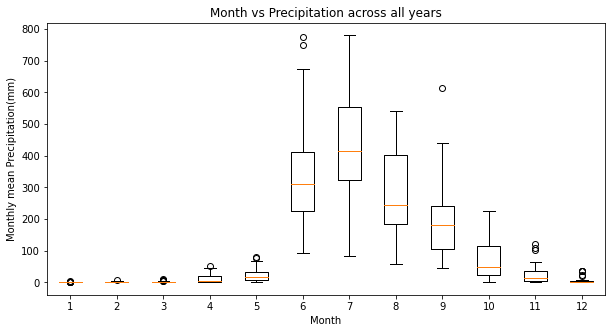

In [8]:
plt.figure(figsize=(10,5))
plt.boxplot(rainfall_data_matrix)
plt.xlabel('Month')
plt.ylabel('Monthly mean Precipitation(mm)')
plt.title('Month vs Precipitation across all years')

In [12]:
rainfall_data_matrix_np = rainfall_data_matrix.transpose().values
shape = rainfall_data_matrix_np.shape
rainfall_data_matrix_np = rainfall_data_matrix_np.reshape((shape[0] * shape[1], 1))

In [14]:
rainfall_data = pd.DataFrame({'Precipitation': rainfall_data_matrix_np[:,0]})
rainfall_data.set_index(dates, inplace=True)

test_rainfall_data = rainfall_data.loc['1995': '2002']
rainfall_data = rainfall_data.loc[: '1994']
rainfall_data.head()

,Precipitation
1965-01-01,0.029
1965-02-01,0.069
1965-03-01,0.000
1965-04-01,21.667
1965-05-01,17.859


Text(0.5, 1.0, 'Precipitation in mm')

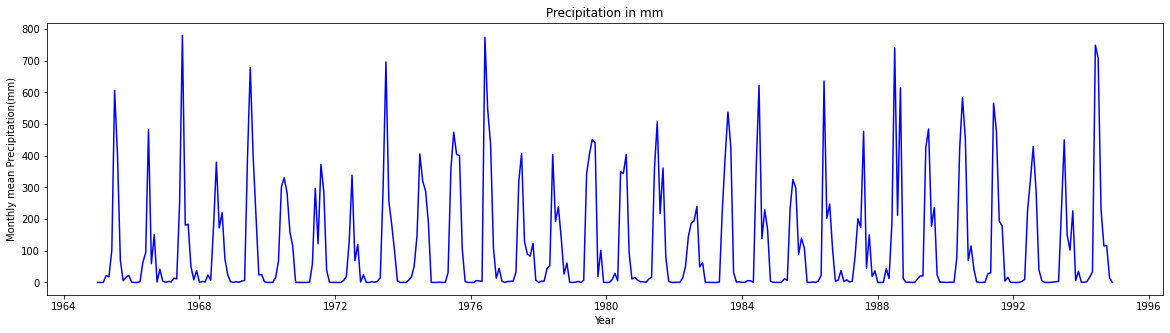

In [15]:
plt.figure(figsize=(20,5))
plt.plot(rainfall_data, color='blue')
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation(mm)')
plt.title('Precipitation in mm')

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_data = scaler.fit_transform(rainfall_data)
test_data = scaler.fit_transform(test_rainfall_data)

In [23]:
rainfall_data.head()

,Precipitation
1965-01-01,0.029
1965-02-01,0.069
1965-03-01,0.000
1965-04-01,21.667
1965-05-01,17.859


In [24]:
train_data[:5]

array([[3.71792012e-05],
       [8.84608580e-05],
       [0.00000000e+00],
       [2.77779915e-02],
       [2.28959777e-02]])

In [25]:
scaler.inverse_transform(train_data[:5])

array([[ 0.0250525 ],
       [ 0.05960767],
       [ 0.        ],
       [18.71767176],
       [15.42801957]])

In [26]:
print("Shape of train data: " + str(train_data.shape))
print("Shape of test data: " + str(test_data.shape))

Shape of train data: (360, 1)
Shape of test data: (96, 1)


In [27]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)

In [28]:
look_back = 3
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

In [29]:
print("Shape of train input: " + str(trainX.shape))
print("Shape of train labels: " + str(trainY.shape))
print("Shape of test input: " + str(testX.shape))
print("Shape of test labels: " + str(testY.shape))

Shape of train input: (356, 3)
Shape of train labels: (356,)
Shape of test input: (92, 3)
Shape of test labels: (92,)


In [30]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [31]:
print("Shape of train input: " + str(trainX.shape))
print("Shape of train labels: " + str(trainY.shape))
print("Shape of test input: " + str(testX.shape))
print("Shape of test labels: " + str(testY.shape))

Shape of train input: (356, 1, 3)
Shape of train labels: (356,)
Shape of test input: (92, 1, 3)
Shape of test labels: (92,)


In [32]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

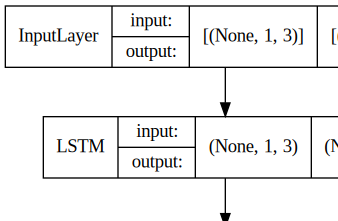

In [33]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def plot_keras_model(model, show_shapes=True, show_layer_names=True):
    return SVG(model_to_dot(model, show_shapes=show_shapes, show_layer_names=show_layer_names).create(prog='dot',format='svg'))

plot_keras_model(model, show_shapes=True, show_layer_names=False)

In [34]:
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
356/356 - 2s - loss: 0.0474 - 2s/epoch - 7ms/step
Epoch 2/100
356/356 - 1s - loss: 0.0396 - 530ms/epoch - 1ms/step
Epoch 3/100
356/356 - 0s - loss: 0.0375 - 494ms/epoch - 1ms/step
Epoch 4/100
356/356 - 1s - loss: 0.0362 - 508ms/epoch - 1ms/step
Epoch 5/100
356/356 - 1s - loss: 0.0353 - 569ms/epoch - 2ms/step
Epoch 6/100
356/356 - 1s - loss: 0.0349 - 502ms/epoch - 1ms/step
Epoch 7/100
356/356 - 1s - loss: 0.0346 - 513ms/epoch - 1ms/step
Epoch 8/100
356/356 - 0s - loss: 0.0340 - 488ms/epoch - 1ms/step
Epoch 9/100
356/356 - 1s - loss: 0.0339 - 545ms/epoch - 2ms/step
Epoch 10/100
356/356 - 1s - loss: 0.0337 - 530ms/epoch - 1ms/step
Epoch 11/100
356/356 - 1s - loss: 0.0331 - 596ms/epoch - 2ms/step
Epoch 12/100
356/356 - 1s - loss: 0.0331 - 572ms/epoch - 2ms/step
Epoch 13/100
356/356 - 1s - loss: 0.0329 - 581ms/epoch - 2ms/step
Epoch 14/100
356/356 - 1s - loss: 0.0328 - 518ms/epoch - 1ms/step
Epoch 15/100
356/356 - 1s - loss: 0.0326 - 521ms/epoch - 1ms/step
Epoch 16/100
356/356 -

In [35]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [36]:
testPredict[:5]

array([[0.05852173],
       [0.14442685],
       [0.13080119],
       [0.41229528],
       [0.38887805]], dtype=float32)

In [37]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [38]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 107.28 RMSE
Test Score: 132.09 RMSE


In [39]:
dates = pd.date_range(start='1965-04', freq='MS', periods=trainY.shape[1])

In [40]:
trainActual = pd.DataFrame({'Precipitation': trainY[0]})
trainActual.index = dates

trainPredictdf = pd.DataFrame({'Precipitation': trainPredict[:,0]})
trainPredictdf.index = dates

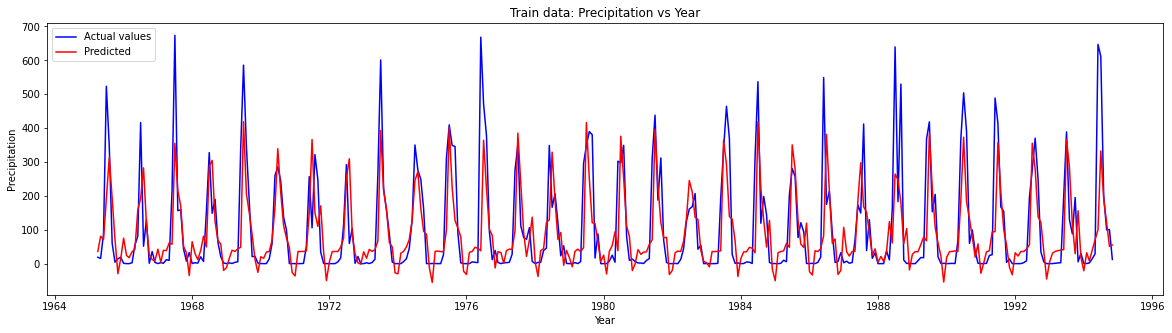

In [41]:
plt.figure(figsize=(20,5))
plt.plot(trainActual, color='blue', label='Actual values')
plt.plot(trainPredictdf, color='red', label='Predicted')
plt.title('Train data: Precipitation vs Year')
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.legend(loc='best')

In [45]:
import pandas as pd                                            # your code
date = pd.date_range('2004-01-01', '2018-01-01', freq="AS")    # your code

freq = 'D'                                                     # 'H' for hours, etc.
date = date + pd.Timedelta(3, unit=freq)                       # Perform the action
print(date)

DatetimeIndex(['2004-01-04', '2005-01-04', '2006-01-04', '2007-01-04',
               '2008-01-04', '2009-01-04', '2010-01-04', '2011-01-04',
               '2012-01-04', '2013-01-04', '2014-01-04', '2015-01-04',
               '2016-01-04', '2017-01-04', '2018-01-04'],
              dtype='datetime64[ns]', freq=None)
